In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Data

In [5]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [6]:
df["quarter"] = df.Date.dt.quarter

In [7]:
df.head()

,Date,Temp,quarter
0,1981-01-01,20.7,1
1,1981-01-02,17.9,1
2,1981-01-03,18.8,1
3,1981-01-04,14.6,1
4,1981-01-05,15.8,1


In [8]:
df = pd.get_dummies(df, columns=["quarter"])

In [9]:
df.head()

,Date,Temp,quarter_1,quarter_2,quarter_3,quarter_4
0,1981-01-01,20.7,True,False,False,False
1,1981-01-02,17.9,True,False,False,False
2,1981-01-03,18.8,True,False,False,False
3,1981-01-04,14.6,True,False,False,False
4,1981-01-05,15.8,True,False,False,False


In [11]:
df.set_index("Date", inplace=True)

In [12]:
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,True,False,False,False
1981-01-02,17.9,True,False,False,False
1981-01-03,18.8,True,False,False,False
1981-01-04,14.6,True,False,False,False
1981-01-05,15.8,True,False,False,False


<Axes: xlabel='Date'>

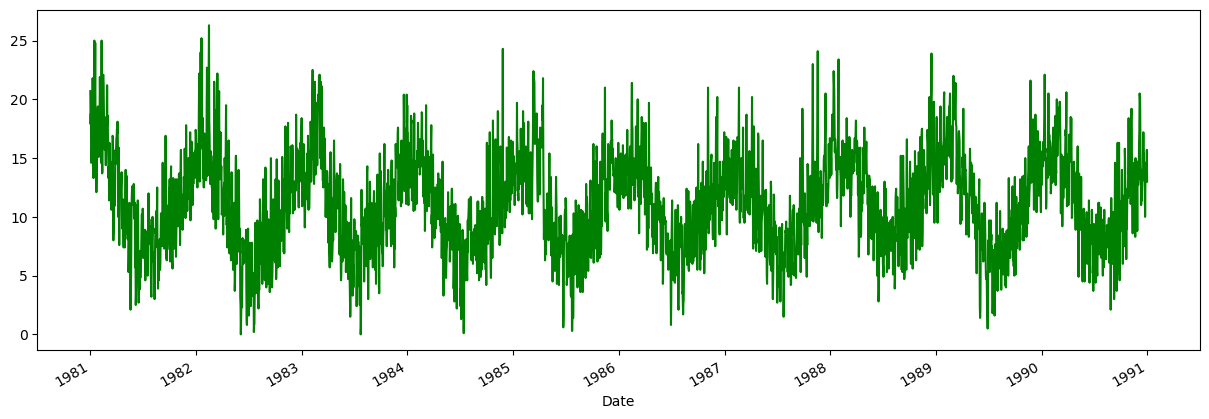

In [13]:
df.Temp.plot(figsize=(15, 5), color="g")

In [29]:
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,True,False,False,False
1981-01-02,17.9,True,False,False,False
1981-01-03,18.8,True,False,False,False
1981-01-04,14.6,True,False,False,False
1981-01-05,15.8,True,False,False,False


# Scalling

In [ ]:
# df.Temp = df.Temp.transform(lambda x: (x - x.mean()) / x.std())

In [46]:
df.quarter_1 = df.quarter_1.apply(lambda x: 1 if x else 0)
df.quarter_2 = df.quarter_2.apply(lambda x: 1 if x else 0)
df.quarter_3 = df.quarter_3.apply(lambda x: 1 if x else 0)
df.quarter_4 = df.quarter_4.apply(lambda x: 1 if x else 0)

In [47]:
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


# Dataset Splitting

In [48]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape
# ts_train.values

((2920, 5), (730, 5))

dtype('bool')

# Dataset & Dataloader

In [49]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [78]:
bs = 32
seq_len = 28
train_set = TimeSeriesDataset(ts_train, "Temp", seq_len=seq_len)
trainloader = DataLoader(train_set, batch_size=bs)


test_set = TimeSeriesDataset(ts_test, "Temp", seq_len=seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (104, 28, 5)
Note: last 7 data excluded

(N, S, F): (26, 28, 5)
Note: last 1 data excluded



# Arsitekstur & Config

In [70]:
from jcopdl.layers import linear_block

In [79]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden


In [80]:
config = set_config({
    "input_size" : train_set.n_feature,
    "output_size" : 1,
    "hidden_size" : 64,
    "num_layers" : 3,
    "dropout" : 0,
    "seq_len" : train_set.n_seq,
})

# Training Preparation -> MCOC

In [81]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config=config, outdir="model/multivar")

# Training

In [73]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None) # feedforward
        loss = criterion(output, target)
        if mode == "train":
            loss.backward() # backpropragation
            optimizer.step() # update weight
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 133.2083 | Test_cost  = 127.7013 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 114.2094 | Test_cost  = 107.5888 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 95.0670 | Test_cost  = 89.5931 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 78.9212 | Test_cost  = 76.0845 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 67.1963 | Test_cost  = 66.6234 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 59.0783 | Test_cost  = 59.9114 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 53.2740 | Test_cost  = 54.8222 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 48.8046 | Test_cost  = 50.6748 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 45.1137 | Test_cost  = 47.1127 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 41.9207 | Test_cost  = 43.9626 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 39.0907 | Test_cost  = 41.1371 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 36.5544 | Test_cost  = 38.5867 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 34.2714 | Test_cost  = 36.2801 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 32.2148 | Test_cost  = 34.1940 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 30.3640 | Test_cost  = 32.3094 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 28.7013 | Test_cost  = 30.6096 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 27.2111 | Test_cost  = 29.0794 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 25.8786 | Test_cost  = 27.7044 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 24.6903 | Test_cost  = 26.4715 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 23.6333 | Test_cost  = 25.3681 | 


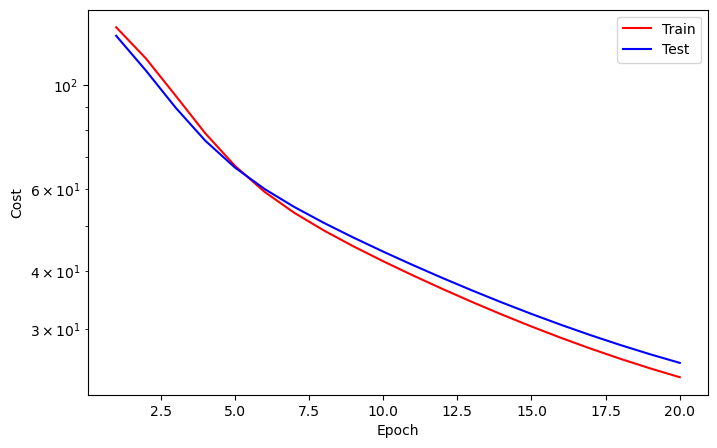

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 22.6955 | Test_cost  = 24.3827 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 21.8658 | Test_cost  = 23.5042 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 21.1336 | Test_cost  = 22.7226 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 20.4892 | Test_cost  = 22.0284 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 19.9236 | Test_cost  = 21.4129 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 19.4282 | Test_cost  = 20.8677 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 18.9952 | Test_cost  = 20.3850 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 18.6172 | Test_cost  = 19.9577 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 18.2878 | Test_cost  = 19.5802 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 18.0020 | Test_cost  = 19.2485 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 17.7558 | Test_cost  = 18.9584 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 17.5450 | Test_cost  = 18.7052 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 17.3649 | Test_cost  = 18.4845 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 17.2116 | Test_cost  = 18.2924 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 17.0814 | Test_cost  = 18.1254 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 16.9711 | Test_cost  = 17.9805 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 16.8780 | Test_cost  = 17.8548 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 16.7996 | Test_cost  = 17.7460 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 16.7337 | Test_cost  = 17.6517 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 16.6785 | Test_cost  = 17.5702 | 


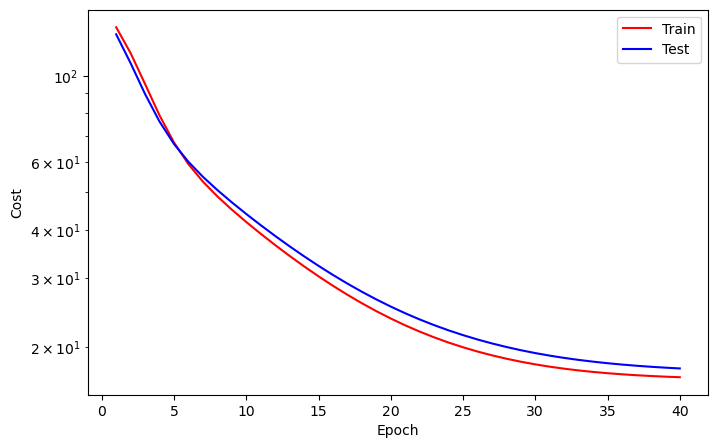

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 16.6322 | Test_cost  = 17.4997 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 16.5936 | Test_cost  = 17.4386 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 16.5613 | Test_cost  = 17.3858 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 16.5343 | Test_cost  = 17.3402 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 16.5117 | Test_cost  = 17.3006 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 16.4929 | Test_cost  = 17.2664 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 16.4771 | Test_cost  = 17.2367 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 16.4638 | Test_cost  = 17.2110 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 16.4527 | Test_cost  = 17.1888 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 16.4434 | Test_cost  = 17.1695 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 16.4354 | Test_cost  = 17.1527 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 16.4287 | Test_cost  = 17.1382 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 16.4230 | Test_cost  = 17.1256 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 16.4181 | Test_cost  = 17.1147 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 16.4139 | Test_cost  = 17.1052 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 16.4102 | Test_cost  = 17.0969 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 16.4070 | Test_cost  = 17.0897 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 16.4042 | Test_cost  = 17.0835 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 16.4017 | Test_cost  = 17.0781 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 16.3995 | Test_cost  = 17.0734 | 


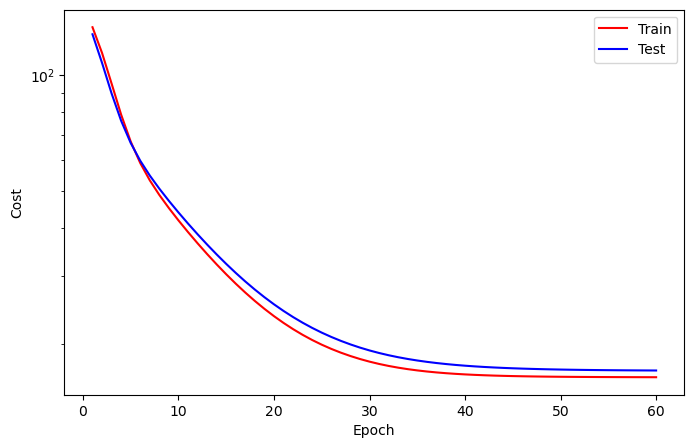

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 16.3975 | Test_cost  = 17.0693 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 16.3957 | Test_cost  = 17.0657 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 16.3941 | Test_cost  = 17.0626 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 16.3926 | Test_cost  = 17.0599 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 16.3912 | Test_cost  = 17.0575 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 16.3898 | Test_cost  = 17.0554 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 16.3886 | Test_cost  = 17.0535 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 16.3874 | Test_cost  = 17.0519 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 16.3863 | Test_cost  = 17.0504 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 16.3852 | Test_cost  = 17.0491 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 16.3842 | Test_cost  = 17.0479 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 16.3831 | Test_cost  = 17.0468 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 16.3821 | Test_cost  = 17.0458 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 16.3811 | Test_cost  = 17.0449 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 16.3801 | Test_cost  = 17.0440 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 16.3792 | Test_cost  = 17.0432 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 16.3782 | Test_cost  = 17.0424 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 16.3772 | Test_cost  = 17.0417 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 16.3762 | Test_cost  = 17.0410 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 16.3753 | Test_cost  = 17.0403 | 


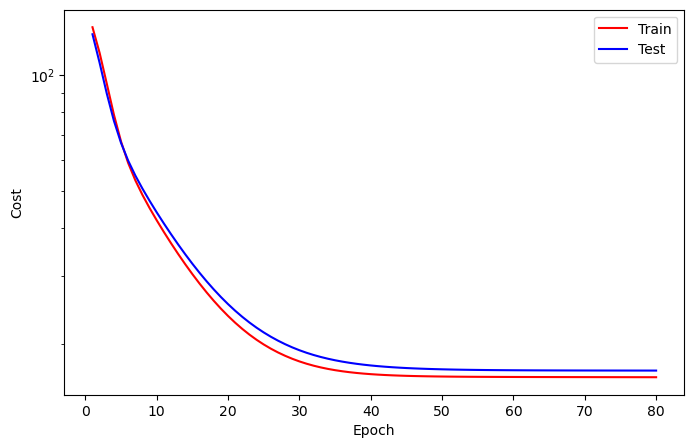

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 16.3743 | Test_cost  = 17.0396 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 16.3733 | Test_cost  = 17.0389 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 16.3723 | Test_cost  = 17.0383 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 16.3713 | Test_cost  = 17.0376 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 16.3703 | Test_cost  = 17.0370 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 16.3693 | Test_cost  = 17.0363 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 16.3683 | Test_cost  = 17.0357 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 16.3672 | Test_cost  = 17.0351 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 16.3662 | Test_cost  = 17.0345 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 16.3651 | Test_cost  = 17.0338 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 16.3640 | Test_cost  = 17.0332 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 16.3629 | Test_cost  = 17.0326 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 16.3618 | Test_cost  = 17.0319 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 16.3607 | Test_cost  = 17.0313 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 16.3596 | Test_cost  = 17.0307 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 16.3584 | Test_cost  = 17.0301 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 16.3573 | Test_cost  = 17.0295 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 16.3561 | Test_cost  = 17.0288 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 16.3549 | Test_cost  = 17.0282 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 16.3537 | Test_cost  = 17.0276 | 


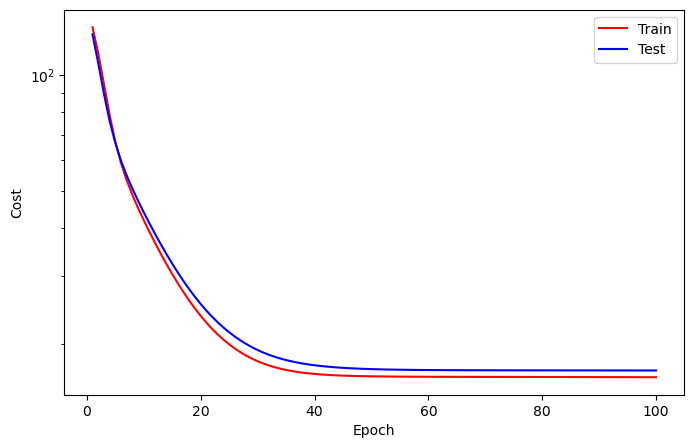

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 16.3524 | Test_cost  = 17.0270 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 16.3512 | Test_cost  = 17.0264 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 16.3499 | Test_cost  = 17.0259 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 16.3486 | Test_cost  = 17.0253 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 16.3472 | Test_cost  = 17.0248 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 16.3459 | Test_cost  = 17.0242 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 16.3445 | Test_cost  = 17.0238 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 16.3430 | Test_cost  = 17.0233 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 16.3415 | Test_cost  = 17.0229 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 16.3400 | Test_cost  = 17.0224 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 16.3384 | Test_cost  = 17.0220 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 16.3367 | Test_cost  = 17.0216 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 16.3350 | Test_cost  = 17.0210 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 16.3332 | Test_cost  = 17.0202 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 16.3312 | Test_cost  = 17.0190 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 16.3289 | Test_cost  = 17.0174 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 16.3265 | Test_cost  = 17.0152 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 16.3237 | Test_cost  = 17.0126 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 16.3206 | Test_cost  = 17.0095 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 16.3171 | Test_cost  = 17.0060 | 


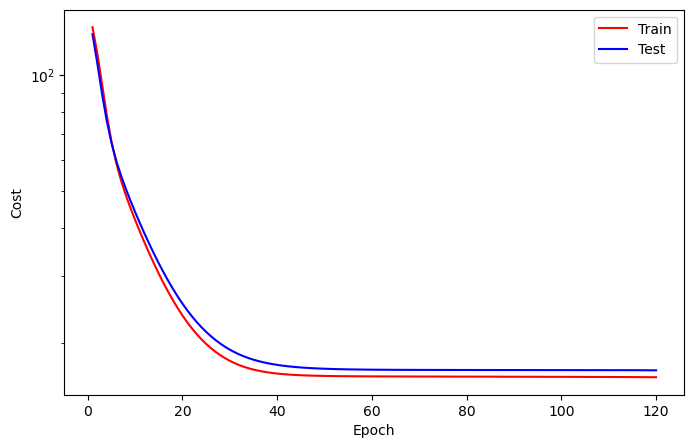

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 16.3134 | Test_cost  = 17.0021 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 16.3092 | Test_cost  = 16.9978 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 16.3047 | Test_cost  = 16.9932 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 16.2998 | Test_cost  = 16.9883 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 16.2943 | Test_cost  = 16.9830 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 16.2884 | Test_cost  = 16.9773 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 16.2817 | Test_cost  = 16.9712 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 16.2743 | Test_cost  = 16.9645 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 16.2660 | Test_cost  = 16.9571 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 16.2563 | Test_cost  = 16.9490 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 16.2450 | Test_cost  = 16.9398 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 16.2312 | Test_cost  = 16.9289 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 16.2134 | Test_cost  = 16.9154 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 16.1886 | Test_cost  = 16.8967 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 16.1493 | Test_cost  = 16.8655 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 16.0742 | Test_cost  = 16.7944 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 15.8952 | Test_cost  = 16.5294 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 15.4308 | Test_cost  = 15.1685 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 14.2248 | Test_cost  = 14.2070 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 13.2376 | Test_cost  = 13.6409 | 


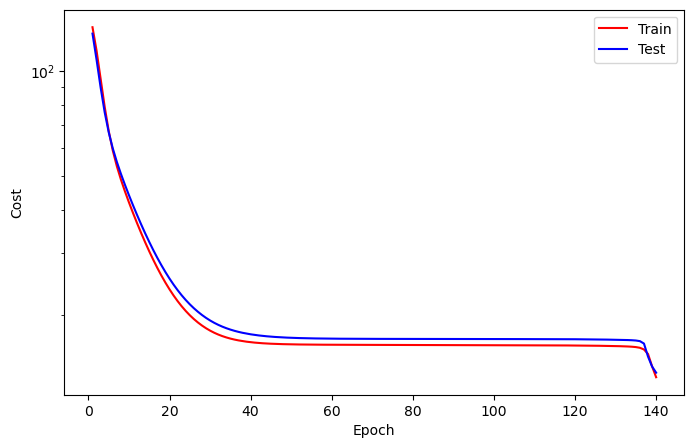

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 12.6839 | Test_cost  = 12.8508 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 11.9548 | Test_cost  = 12.0730 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 11.3562 | Test_cost  = 11.5131 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 10.9191 | Test_cost  = 10.9731 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 10.4791 | Test_cost  = 10.4794 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 10.1040 | Test_cost  = 10.0612 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 9.7757 | Test_cost  = 9.6936 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 9.4992 | Test_cost  = 9.3519 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 9.2302 | Test_cost  = 9.0698 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 9.0198 | Test_cost  = 8.8093 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 8.8022 | Test_cost  = 8.5971 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 8.6286 | Test_cost  = 8.3891 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 8.4464 | Test_cost  = 8.1928 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 8.2877 | Test_cost  = 7.9980 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 8.1269 | Test_cost  = 7.8276 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 7.9915 | Test_cost  = 7.6675 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 7.8590 | Test_cost  = 7.5206 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 7.7451 | Test_cost  = 7.3765 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 7.6348 | Test_cost  = 7.2432 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 7.5380 | Test_cost  = 7.1198 | 


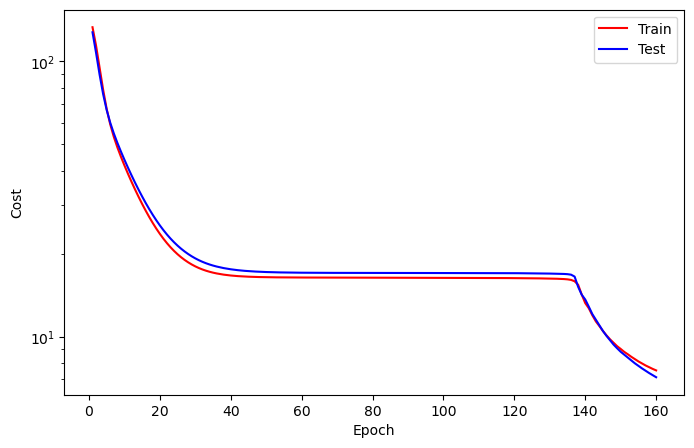

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 7.4483 | Test_cost  = 7.0067 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 7.3676 | Test_cost  = 6.9021 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 7.2948 | Test_cost  = 6.8047 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 7.2270 | Test_cost  = 6.7174 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 7.1668 | Test_cost  = 6.6374 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 7.1100 | Test_cost  = 6.5650 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 7.0584 | Test_cost  = 6.4979 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 7.0094 | Test_cost  = 6.4363 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 6.9629 | Test_cost  = 6.3792 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 6.9187 | Test_cost  = 6.3251 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 6.8760 | Test_cost  = 6.2731 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 6.8351 | Test_cost  = 6.2227 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 6.7951 | Test_cost  = 6.1742 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 6.7568 | Test_cost  = 6.1271 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 6.7194 | Test_cost  = 6.0816 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 6.6836 | Test_cost  = 6.0374 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 6.6489 | Test_cost  = 5.9952 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 6.6159 | Test_cost  = 5.9544 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 6.5843 | Test_cost  = 5.9152 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 6.5540 | Test_cost  = 5.8779 | 


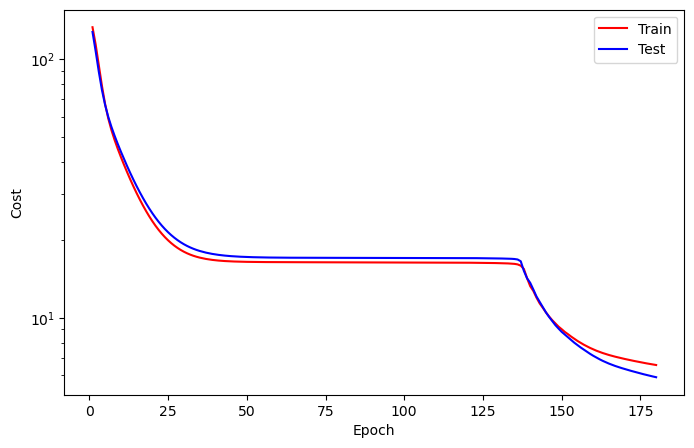

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 6.5251 | Test_cost  = 5.8421 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 6.4973 | Test_cost  = 5.8081 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 6.4709 | Test_cost  = 5.7755 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 6.4452 | Test_cost  = 5.7446 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 6.4208 | Test_cost  = 5.7152 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 6.3972 | Test_cost  = 5.6871 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 6.3744 | Test_cost  = 5.6604 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 6.3527 | Test_cost  = 5.6349 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 6.3315 | Test_cost  = 5.6105 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 6.3111 | Test_cost  = 5.5873 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 6.2916 | Test_cost  = 5.5648 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 6.2725 | Test_cost  = 5.5434 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 6.2542 | Test_cost  = 5.5232 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 6.2366 | Test_cost  = 5.5034 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 6.2195 | Test_cost  = 5.4848 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 6.2030 | Test_cost  = 5.4670 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 6.1871 | Test_cost  = 5.4500 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 6.1716 | Test_cost  = 5.4335 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 6.1566 | Test_cost  = 5.4177 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 6.1420 | Test_cost  = 5.4028 | 


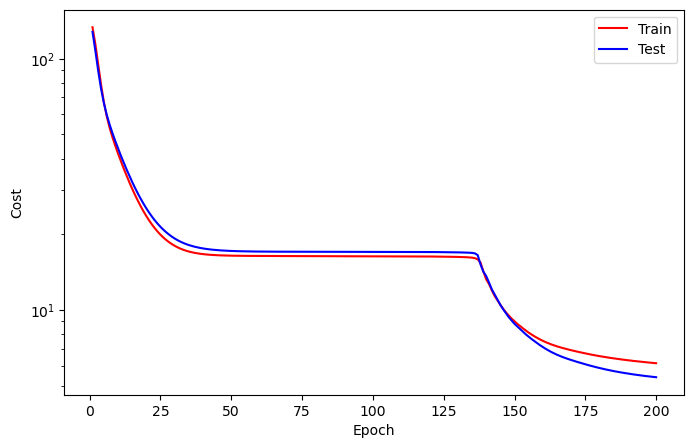

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 6.1280 | Test_cost  = 5.3884 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 6.1144 | Test_cost  = 5.3747 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 6.1011 | Test_cost  = 5.3614 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 6.0883 | Test_cost  = 5.3486 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 6.0757 | Test_cost  = 5.3365 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 6.0636 | Test_cost  = 5.3247 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 6.0517 | Test_cost  = 5.3132 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 6.0402 | Test_cost  = 5.3022 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 6.0290 | Test_cost  = 5.2915 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 6.0181 | Test_cost  = 5.2811 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 6.0074 | Test_cost  = 5.2710 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 5.9969 | Test_cost  = 5.2613 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 5.9867 | Test_cost  = 5.2520 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 5.9768 | Test_cost  = 5.2429 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 5.9671 | Test_cost  = 5.2340 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 5.9576 | Test_cost  = 5.2255 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 5.9483 | Test_cost  = 5.2172 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 5.9391 | Test_cost  = 5.2092 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 5.9301 | Test_cost  = 5.2014 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 5.9214 | Test_cost  = 5.1938 | 


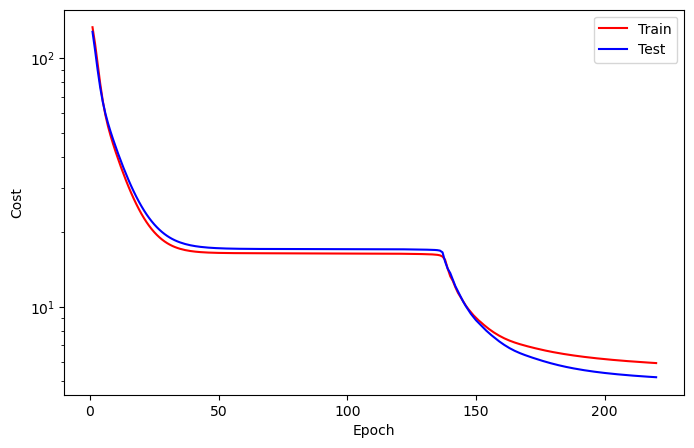

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 5.9127 | Test_cost  = 5.1863 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 5.9042 | Test_cost  = 5.1791 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 5.8958 | Test_cost  = 5.1723 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 5.8876 | Test_cost  = 5.1657 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 5.8797 | Test_cost  = 5.1591 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 5.8717 | Test_cost  = 5.1529 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 5.8639 | Test_cost  = 5.1472 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 5.8563 | Test_cost  = 5.1417 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 5.8487 | Test_cost  = 5.1365 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 5.8414 | Test_cost  = 5.1316 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 5.8341 | Test_cost  = 5.1267 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 5.8271 | Test_cost  = 5.1223 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 5.8203 | Test_cost  = 5.1180 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 5.8134 | Test_cost  = 5.1141 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 5.8068 | Test_cost  = 5.1105 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 5.8003 | Test_cost  = 5.1071 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 5.7939 | Test_cost  = 5.1042 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 5.7878 | Test_cost  = 5.1015 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 5.7818 | Test_cost  = 5.0991 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 5.7757 | Test_cost  = 5.0971 | 


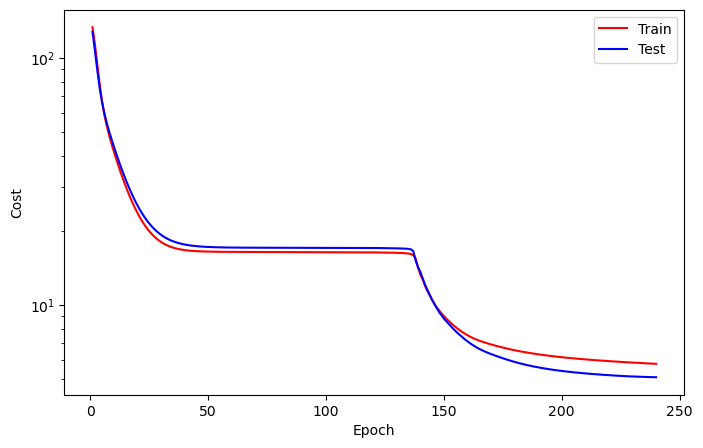

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 5.7699 | Test_cost  = 5.0953 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 5.7643 | Test_cost  = 5.0938 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 5.7585 | Test_cost  = 5.0924 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 5.7529 | Test_cost  = 5.0913 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 5.7476 | Test_cost  = 5.0904 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 5.7423 | Test_cost  = 5.0895 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 5.7368 | Test_cost  = 5.0891 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 5.7316 | Test_cost  = 5.0886 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 5.7263 | Test_cost  = 5.0885 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 5.7212 | Test_cost  = 5.0884 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 5.7160 | Test_cost  = 5.0885 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0884


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 5.7109 | Test_cost  = 5.0887 | 
==> EarlyStop patience =  2 | Best test_cost: 5.0884


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 5.7058 | Test_cost  = 5.0891 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0884


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 5.7006 | Test_cost  = 5.0895 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0884


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 5.6954 | Test_cost  = 5.0902 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0884
==> Execute Early Stopping at epoch: 255 | Best test_cost: 5.0884
==> Best model is saved at model/multivar


/home/zaens/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/jcopdl/callback/_callback.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load

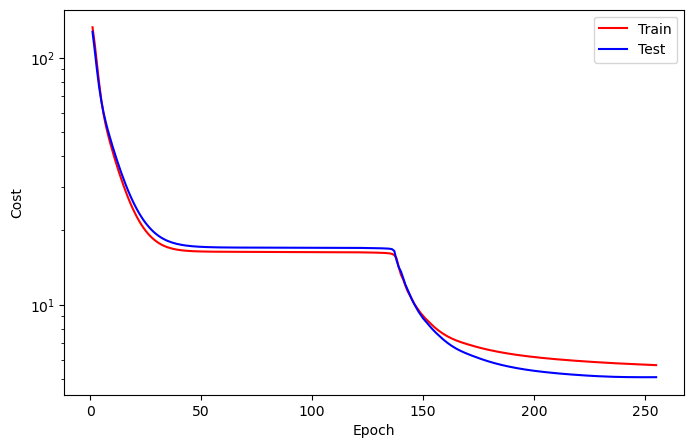

In [82]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecasting

In [35]:
from luwiji.rnn import illustration

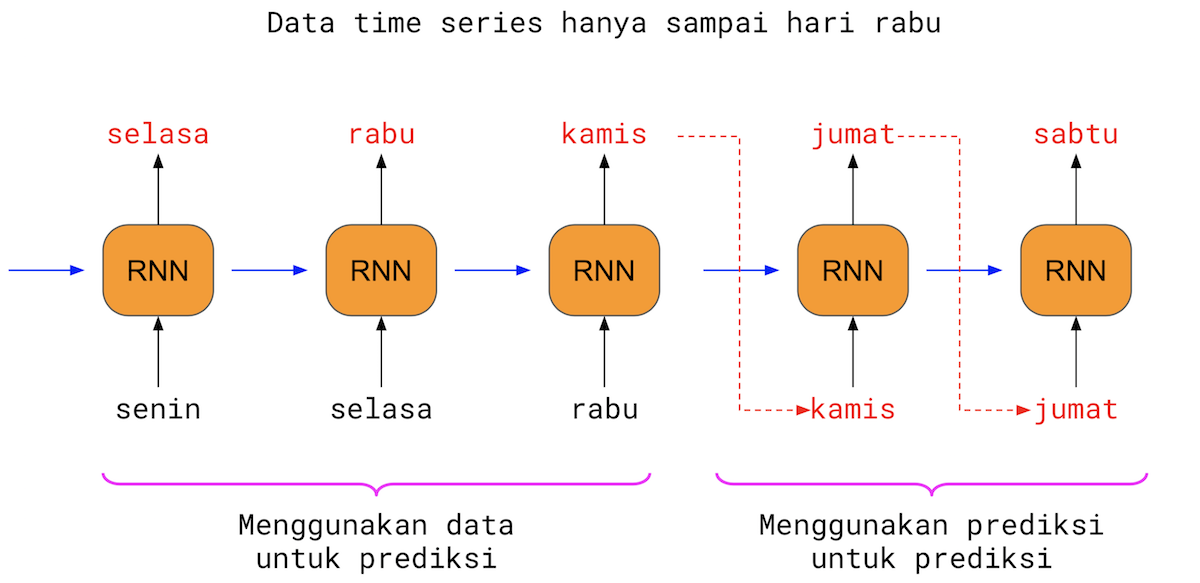

In [36]:
illustration.forecast

In [58]:
from utils import data4pred, pred4pred

In [83]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", seq_len=1)
trainforecastloader = DataLoader(train_forecast_set)


test_forecast_set = TimeSeriesDataset(ts_test, "Temp", seq_len=1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

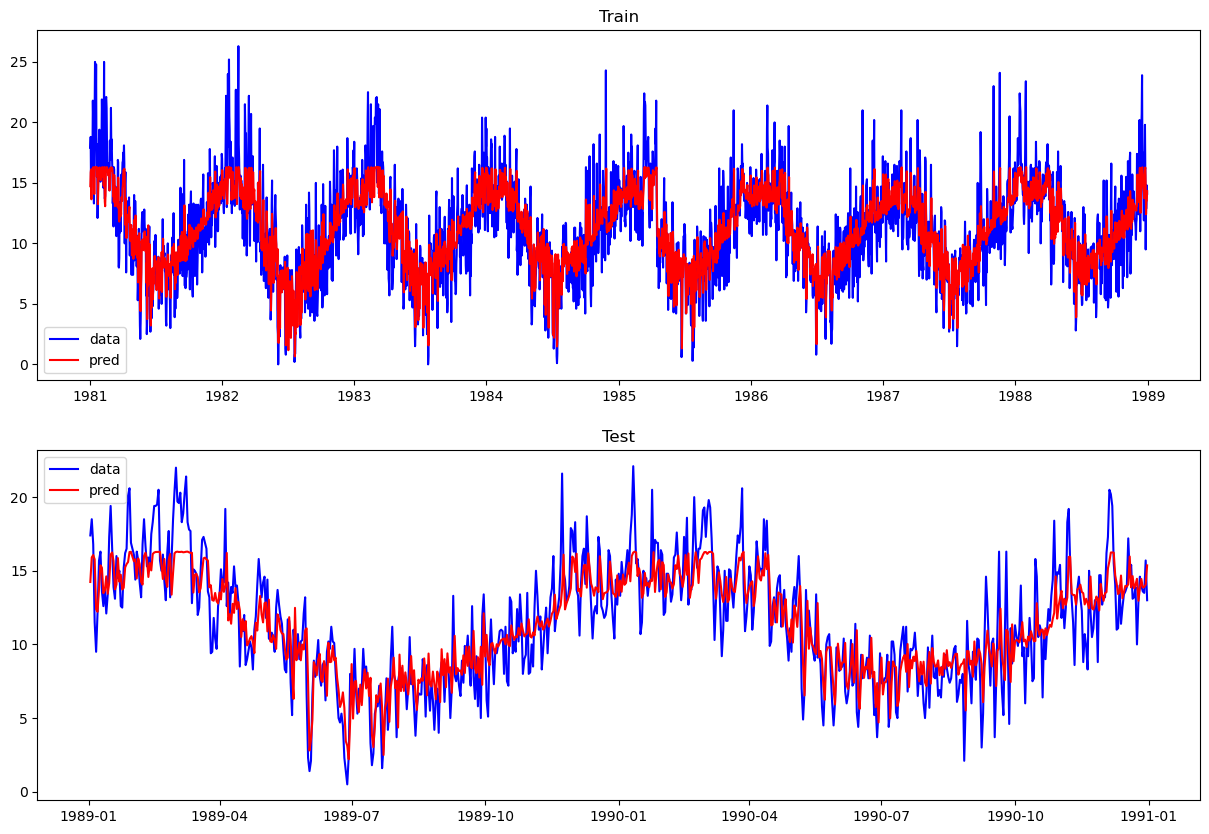

In [84]:
plt.figure(figsize=(15,10))
plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

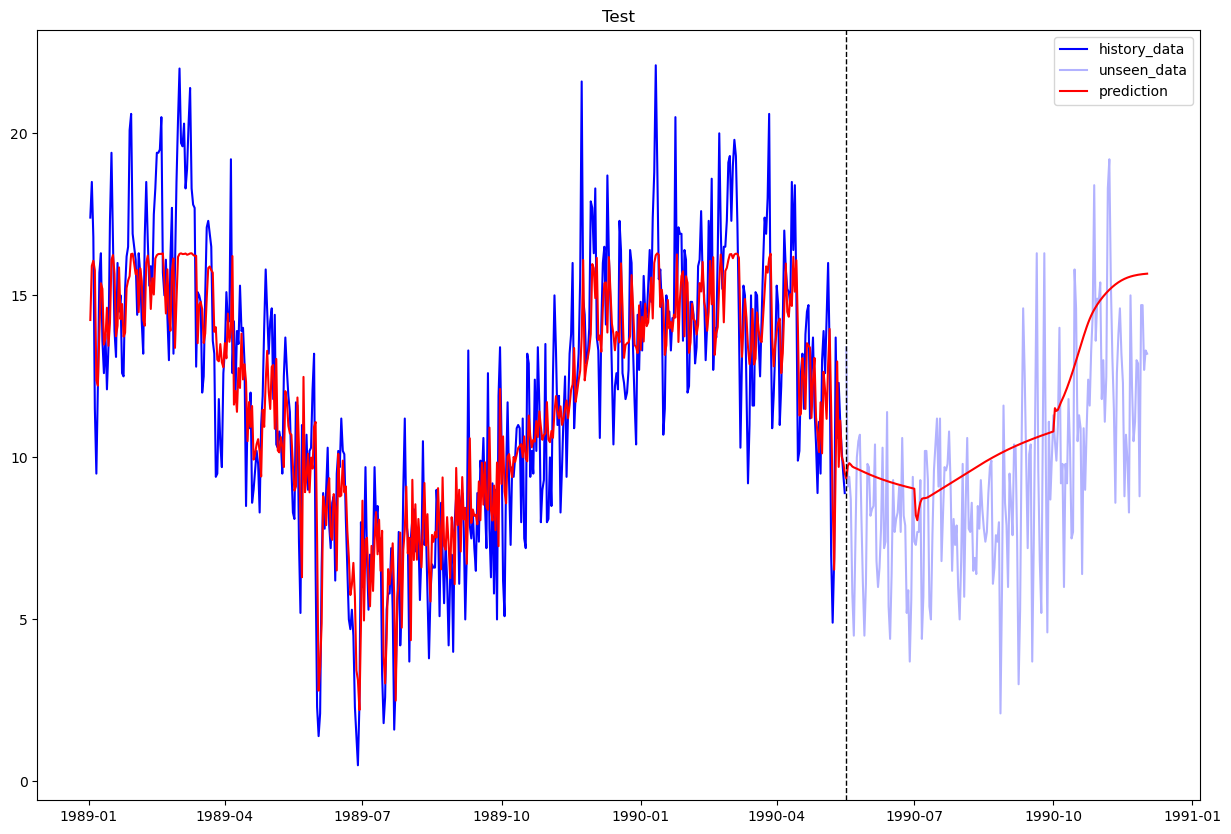

In [85]:
plt.figure(figsize=(15,10))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=500, n_forecast=200)
plt.title("Test")